In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from geopy.geocoders import Nominatim
from collections import Counter
import os
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
import random
import operator

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer, TweetTokenizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF
import string
%matplotlib inline
plt.style.use('ggplot')
# plt.style.use('fivethirtyeight')

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, make_scorer, recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor


## Read in csv data and get into dataframe

In [28]:
data_all = pd.read_csv('../data_output/kplc_tweets.csv')
data_kplc = pd.read_csv('../data_output/kplc_company_tweets.csv')
data = pd.read_csv('../data_output/kplc_customer_tweets.csv')

# Exploring data

Text(0,0.5,u'Number of tweets')

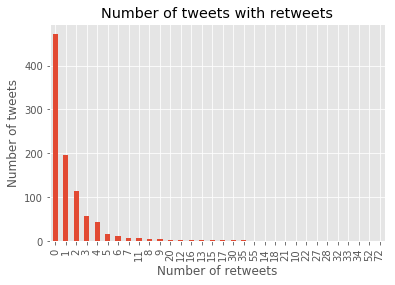

In [29]:
data_kplc['retweets'].value_counts().plot(kind='bar',title='Number of tweets with retweets')
plt.xlabel('Number of retweets')
plt.ylabel('Number of tweets')

Text(0,0.5,u'Number of tweets')

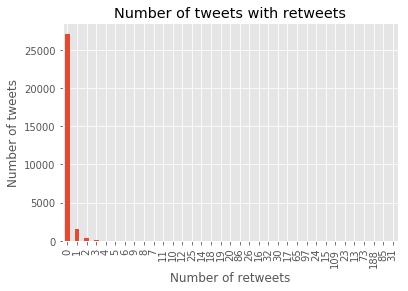

In [30]:
data['retweets'].value_counts().plot(kind='bar',title='Number of tweets with retweets')
plt.xlabel('Number of retweets')
plt.ylabel('Number of tweets')

### Tweet count by month

Text(0.5,1,u'Number of tweets per month')

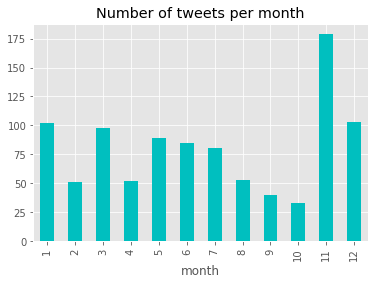

In [31]:
data_kplc.groupby('month')['date'].count().plot(kind='bar',color='c')
plt.title('Number of tweets per month')

Text(0.5,1,u'Number of tweets per month')

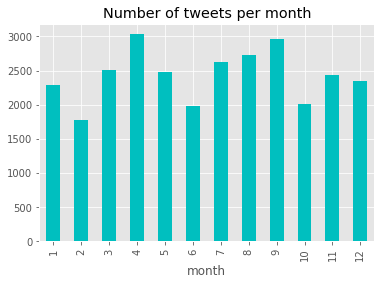

In [32]:
data.groupby('month')['date'].count().plot(kind='bar',color='c')
plt.title('Number of tweets per month')

### Tweet count by Day of Week

Text(0.5,1,u'Number of tweets per day of the week')

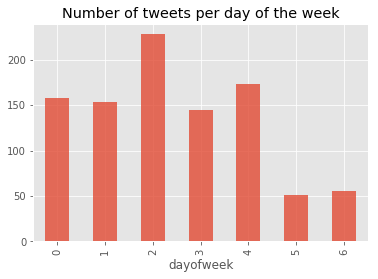

In [33]:
data_kplc.groupby('dayofweek')['date'].count().plot(kind='bar',alpha=0.8)
plt.title('Number of tweets per day of the week')

Text(0.5,1,u'Number of tweets per day of the week')

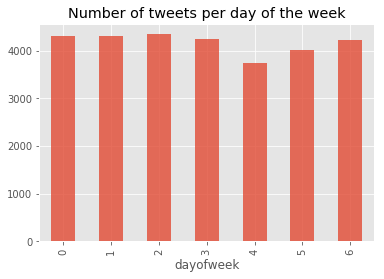

In [34]:
data.groupby('dayofweek')['date'].count().plot(kind='bar',alpha=0.8)
plt.title('Number of tweets per day of the week')

### Tweet count by Hour of Day

Text(0.5,1,u'Number of tweets by hour of the day')

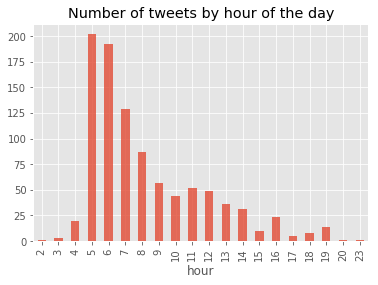

In [35]:
data_kplc.groupby('hour')['date'].count().plot(kind='bar',alpha=0.8)
plt.title('Number of tweets by hour of the day')

Text(0.5,1,u'Number of tweets by hour of the day')

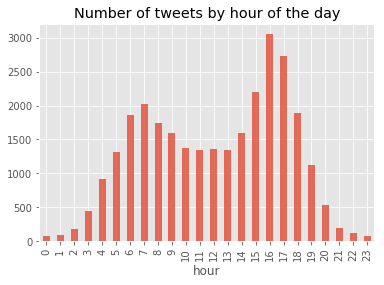

In [36]:
data.groupby('hour')['date'].count().plot(kind='bar',alpha=0.8)
plt.title('Number of tweets by hour of the day')

### Tweet count by Day of Year

Text(0.5,1,u'Number of tweets over time')

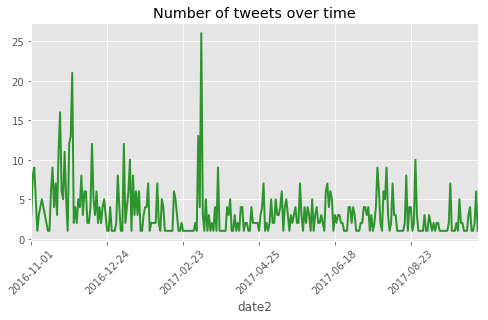

In [37]:
data_kplc.groupby('date2')['date'].count().plot(kind='line',figsize=(8,4),linewidth=2,alpha=0.8, c='g')
plt.xticks(rotation=45)
plt.title('Number of tweets over time')

In [38]:
data['date'].min()

'2016-11-01 02:15:00'

In [39]:
data['date'] = pd.to_datetime(data['date'])
data = data[data['date'] < pd.to_datetime('2017-10-20')]

Text(0.5,1,u'Number of tweets over time')

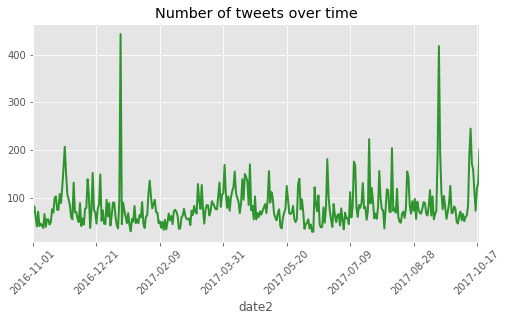

In [40]:
data.groupby('date2')['date'].count().plot(kind='line',figsize=(8,4),linewidth=2,alpha=0.8, c='g')
plt.xticks(rotation=45)
plt.title('Number of tweets over time')

Text(0.5,1,u'Number of retweets over time')

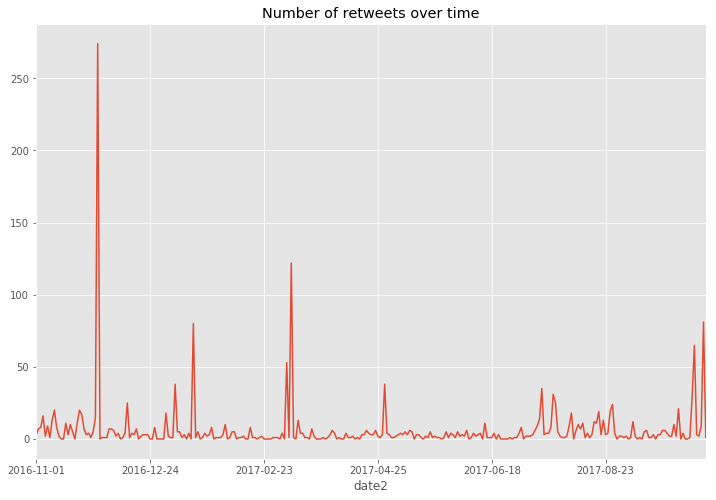

In [41]:
data_kplc.groupby('date2')['retweets'].sum().plot(kind='line',figsize=(12,8))
plt.title('Number of retweets over time')

Text(0.5,1,u'Number of retweets over time')

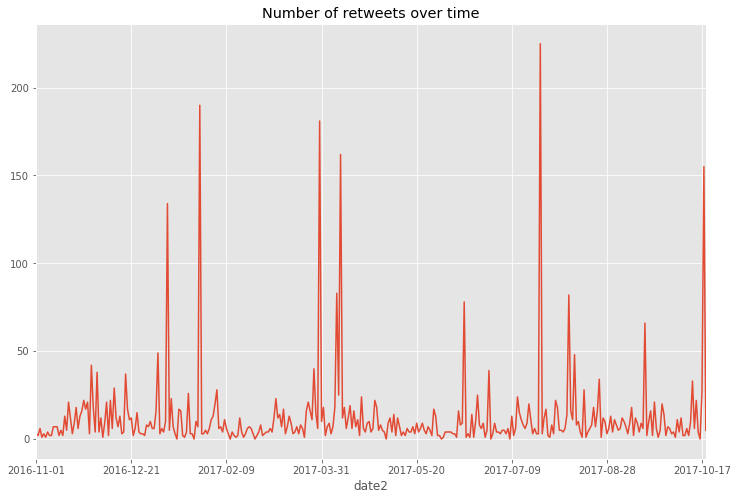

In [42]:
data.groupby('date2')['retweets'].sum().plot(kind='line',figsize=(12,8))
plt.title('Number of retweets over time')

In [45]:
unique = data['mentions'].unique()
individual = []
for collection in unique:
    sub_list = str(collection).split(' ')
    individual.extend(sub_list)

mention_count = Counter(individual)
top_three_mentions = mention_count.most_common(20)[:3]
top_three_mentions

[('@KenyaPower', 1176), ('@KenyaPower_Care', 681), ('@KenyaPowerAlert', 322)]

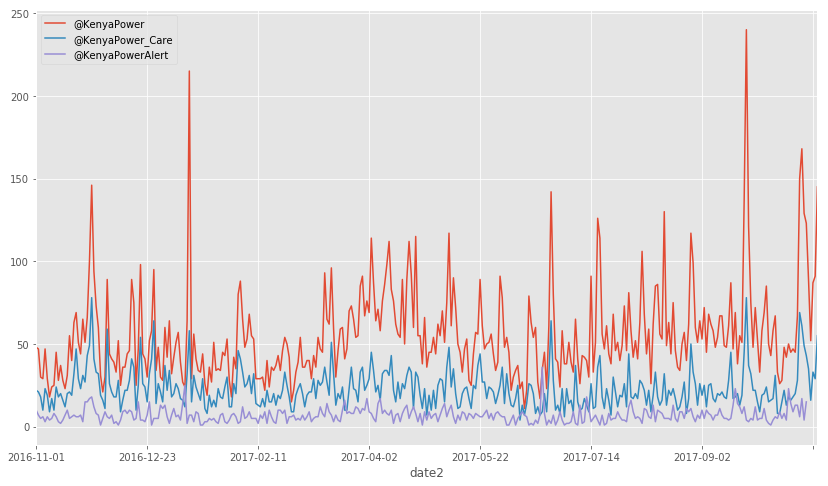

In [46]:
for mention in top_three_mentions:
    temp = data[data['mentions'].str.contains(mention[0],na=False)]
    temp.groupby('date2')['date'].count().plot(kind='line',figsize=(14,8),label=mention[0])
plt.legend(loc='best')
plt.show()

In [47]:
unique = data['hashtags'].unique()
individual = []
for collection in unique:
    sub_list = str(collection).split(' ')
    individual.extend(sub_list)

hashtag_count = Counter(individual)
top_three_hashtags = hashtag_count.most_common(20)[:3]
top_three_hashtags

[('#KPLC', 56), ('#kenyapower', 55), ('#kplc', 50)]

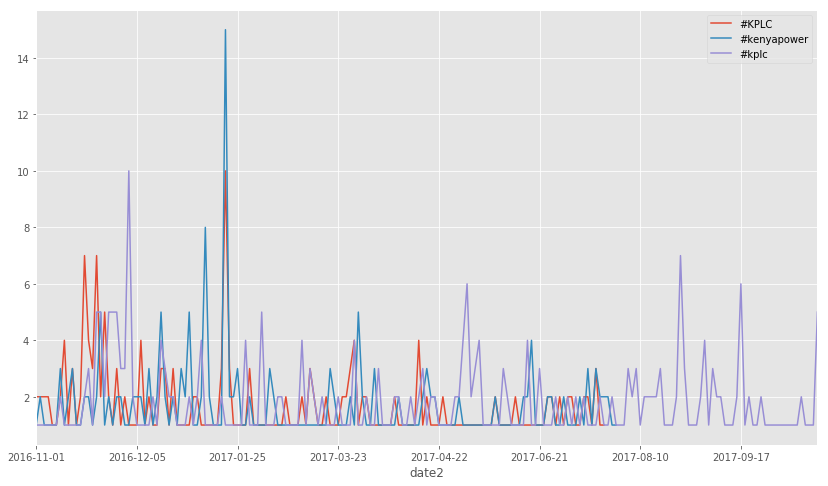

In [48]:
for hashtag in top_three_hashtags:
    temp = data[data['hashtags'].str.contains(hashtag[0],na=False)]
    temp.groupby('date2')['date'].count().plot(kind='line',figsize=(14,8),label=hashtag[0])
plt.legend(loc='best')
plt.show()

In [159]:
tweets = data['text'].values
word_counts = Counter()
for tweet in tweets:
    word_list = tweet.split(' ')
    word_list = [w.lower() for w in word_list if w.isalpha()]
    word_list = [w for w in word_list if w not in STOPWORDS]
    counts = Counter(word_list)
    word_counts += counts


In [163]:
def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(10, 50)
wc = WordCloud(background_color="white", max_words=200,
               stopwords=STOPWORDS, max_font_size=300, random_state=42)
wc.generate_from_frequencies(word_counts)
wc.recolor(color_func=grey_color_func, random_state=3)
wc.to_file("kplc_wordcloud2.png")

![wordcloud](kplc_wordcloud2.png)

In [173]:
word_counts.most_common(10)

[('power', 15051),
 ('since', 5965),
 ('please', 3041),
 ('kindly', 2963),
 ('lights', 2175),
 ('area', 2073),
 ('yesterday', 1907),
 ('blackout', 1904),
 ('last', 1793),
 ('now', 1594)]

In [181]:
data['text'].str.contains('lights').sum()/float(len(data))

0.073598810524274361

## Topic Modeling results

- Topic 1 = General outage complaint
- Topic 2 = Temporal reference
- Topic 3 = Account/Token Help Request

In [49]:
data = pd.read_csv('../data_output/kplc_customer_with_topics.csv')

Text(0.5,1,u'Count of tweet by topic per day')

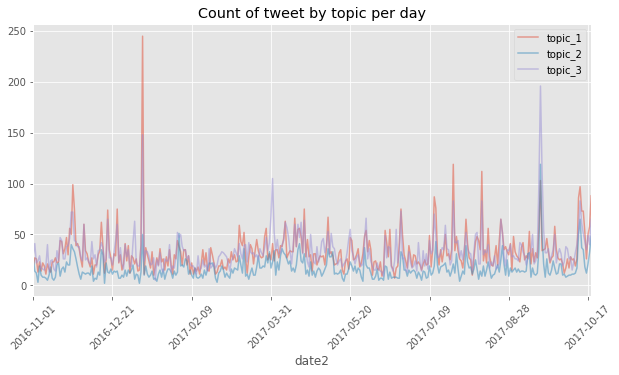

In [51]:
for topic in data['main_topic'].unique():
    data[data['main_topic']==topic].groupby('date2')['username'].count().plot(kind='line',figsize=(10,5),alpha=0.5, label='topic_'+str(topic+1))
plt.legend(loc='best')
plt.xticks(rotation=45)
plt.title('Count of tweet by topic per day')

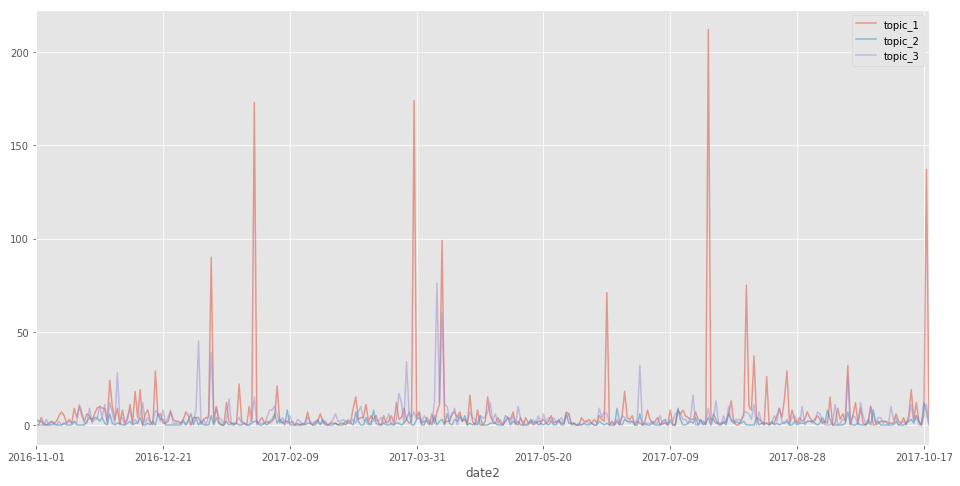

In [52]:
for topic in data['main_topic'].unique():
    data[data['main_topic']==topic].groupby('date2')['retweets'].sum().plot(kind='line',figsize=(16,8),alpha=0.5, label='topic_'+str(topic+1))
plt.legend(loc='best')

In [53]:
for value in data.groupby('main_topic')['text'].count():
    print value/float(30966)

0.372795969773
0.186656332752
0.382871536524


### Train topic classification model...

In [232]:
X = tfidf
y = W.argmax(axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y)


In [233]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)
print 'training accuracy: {}'.format(rfc.score(X_train, y_train))
print 'testing accuracy: {}'.format(rfc.score(X_test, y_test))
y_pred = rfc.predict(X_test)

training accuracy: 0.998442575535
testing accuracy: 0.977840074756


In [234]:
cv_accuracy = cross_val_score(rfc, X_train, y_train, cv=5)
print 'cross validated accuracy: {}'.format(cv_accuracy.mean())

cross validated accuracy: 0.973078676142


In [240]:
for i in xrange(3):
    true = y_test == i
    pred = y_pred ==i
    print 'topic {} accuracy: {}'.format(i, accuracy_score(true, pred))
    print 'topic {} f1: {}'.format(i, f1_score(true, pred))

topic 0 accuracy: 0.986784140969
topic 0 f1: 0.983347350715
topic 1 accuracy: 0.989720998532
topic 1 f1: 0.975328420378
topic 2 accuracy: 0.979175010012
topic 2 f1: 0.973630831643


### Train retweet classification

In [402]:
for i in xrange(4):
    data['topic_'+str(i)] = np.where(data['main_topic']==i,1,0)
for i in xrange(7):
    data['dow_'+str(i)] = np.where(data['dayofweek']==i,1,0)
for i in xrange(24):
    data['hour_'+str(i)] = np.where(data['hour']==i,1,0)

In [403]:
cols_to_include = data.columns[31:]

In [404]:
topics = data[cols_to_include].values
# topics = topics.reshape(len(topics),3)
X = np.concatenate((tfidf,topics),axis=1)
y = data['retweeted'].values

In [405]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [406]:
class_imbalance = y.sum()/float(len(y))
print 'number not retweeted: {}%'.format((1-class_imbalance)*100)
print 'number retweeted: {}%'.format(class_imbalance*100)

number not retweeted: 91.5484823205%
number retweeted: 8.45151767952%


In [407]:
# Address class imbalance:
# Random under sampling
no_retweet_idx = []
for i in range(len(y_train)):
    if y_train[i]==0:
        no_retweet_idx.append(i)
under_sample_idx = np.random.choice(no_retweet_idx, size=len(no_retweet_idx)/4,replace=False)
# Random over sampling
retweet_idx = []
for i in range(len(y_train)):
    if y_train[i]==1:
        retweet_idx.append(i)
over_sample_idx = np.random.choice(retweet_idx, size=len(retweet_idx)*2,replace=True)
# Random over sampling

In [408]:
print len(under_sample_idx)
print len(over_sample_idx)
print len(np.concatenate((over_sample_idx,under_sample_idx),axis=0))
new_idx = np.concatenate((over_sample_idx,under_sample_idx),axis=0)

5343
3998
9341


In [409]:
X_train_balance = X_train[new_idx,:]
y_train_balance = y_train[new_idx]
print y_train_balance.sum()/float(len(y_train_balance))
print y_train.sum()/float(len(y_train))

0.428005566856
0.0855223752888


In [414]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train_balance, y_train_balance)
print 'training accuracy: {}'.format(rfc.score(X_train_balance, y_train_balance))
print 'testing accuracy: {}'.format(rfc.score(X_test, y_test))
y_pred = rfc.predict(X_test)
print 'testing f1: {}'.format(f1_score(y_test, y_pred))
print 'testing recall: {}'.format(recall_score(y_test, y_pred))
print 'testing precision: {}'.format(precision_score(y_test, y_pred))

training accuracy: 0.984369981801
testing accuracy: 0.839065708419
testing f1: 0.21625
testing recall: 0.272440944882
testing precision: 0.179274611399


In [411]:
features = np.append(vocab, cols_to_include)

In [386]:
#rfc.feature_importances_
importances = zip(rfc.feature_importances_,features)
sorted(importances, key=operator.itemgetter(0))[::-1]



[(0.023346934775468328, u'power'),
 (0.015551620359261151, 'dow_0'),
 (0.015049572859044947, 'dow_4'),
 (0.014030968427617896, 'hour_17'),
 (0.013949594135699402, 'dow_3'),
 (0.013811797335557759, 'dow_2'),
 (0.013809882903206708, u'blackout'),
 (0.013442850179778375, 'hour_16'),
 (0.013191757302834107, 'dow_5'),
 (0.013166424508548638, 'dow_1'),
 (0.012376570705054997, 'dow_6'),
 (0.012203904308475051, u'http'),
 (0.011728680945323302, 'hour_15'),
 (0.011324818156640977, u'happen'),
 (0.011238868116376782, u'day'),
 (0.01091935182139777, u'kindli'),
 (0.010840597349819204, u'light'),
 (0.010530985618302541, u'good'),
 (0.010500437231486335, 'hour_6'),
 (0.010360491874732187, u'outag'),
 (0.010345350767531167, u'area'),
 (0.010340708903967891, 'hour_7'),
 (0.0098747254783321751, 'hour_8'),
 (0.0098149500180339053, 'hour_18'),
 (0.0097853297201006741, u'electr'),
 (0.0093283058162819503, u'sinc'),
 (0.0093115480567907485, 'hour_5'),
 (0.0092742519482383844, 'hour_9'),
 (0.00916553670124

In [415]:
topics = data[cols_to_include].values
X = np.concatenate((tfidf,topics),axis=1)
y = data['retweets'].values
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [416]:
# Address class imbalance:
# Random under sampling
no_retweet_idx = []
for i in range(len(y_train)):
    if y_train[i]==0:
        no_retweet_idx.append(i)
under_sample_idx = np.random.choice(no_retweet_idx, size=len(no_retweet_idx)/4,replace=False)
# Random over sampling
retweet_idx = []
for i in range(len(y_train)):
    if y_train[i]>0:
        retweet_idx.append(i)
over_sample_idx = np.random.choice(retweet_idx, size=len(retweet_idx)*2,replace=True)
# Random over sampling

In [417]:
print len(under_sample_idx)
print len(over_sample_idx)
print len(np.concatenate((over_sample_idx,under_sample_idx),axis=0))
new_idx = np.concatenate((over_sample_idx,under_sample_idx),axis=0)

5350
3944
9294


In [418]:
X_train_balance = X_train[new_idx,:]
y_train_balance = y_train[new_idx]

In [419]:
y_train_balance.mean()

1.0558424790187217

In [424]:
rfc = RandomForestRegressor(random_state=42)
rfc.fit(X_train_balance, y_train_balance)
print 'training r2: {}'.format(rfc.score(X_train_balance, y_train_balance))
print 'testing r2: {}'.format(rfc.score(X_test, y_test))
y_pred = rfc.predict(X_test)
y_pred_train = rfc.predict(X_train)
# print 'testing f1: {}'.format(f1_score(y_test, y_pred))

training r2: 0.942833718567
testing r2: -1.56179793126


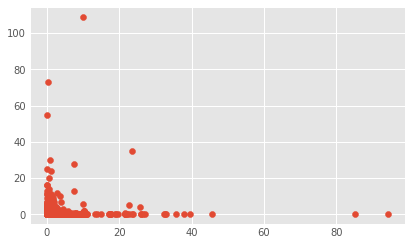

In [425]:
plt.scatter(y_pred, y_test)

In [398]:
#rfc.feature_importances_
features = np.append(vocab, cols_to_include)
importances = zip(rfc.feature_importances_,features)
sorted(importances, key=operator.itemgetter(0))[::-1]

[(0.30736057425249491, 'hour_6'),
 (0.078451899337900949, u'resolv'),
 (0.061701238914644199, u'rain'),
 (0.051979593183325387, u'outag'),
 (0.049259528318682355, 'dow_0'),
 (0.030712819909758493, u'restor'),
 (0.023417341248965603, u'asap'),
 (0.018780492002434077, u'connect'),
 (0.017275119637611674, u'us'),
 (0.017180689529050976, u'yesterday'),
 (0.015634427624315942, 'topic_0'),
 (0.015135212110297192, u'still'),
 (0.013495337327647124, 'dow_2'),
 (0.012958742900731188, 'dow_3'),
 (0.012834856177745343, u'transform'),
 (0.012746915460371617, 'hour_11'),
 (0.011515881723065653, 'hour_13'),
 (0.011008275721978818, u'power'),
 (0.010426499964604864, u'go'),
 (0.010241132489918401, u'follow'),
 (0.0099675220894711661, u'hey'),
 (0.0092755318313725299, u'kenya'),
 (0.0092217499809168664, u'experienc'),
 (0.0090549668762784797, 'hour_7'),
 (0.0083605719007602258, 'hour_10'),
 (0.0069178218997808126, 'hour_8'),
 (0.0061486824830676969, u'electr'),
 (0.0060758712781086716, u'sort'),
 (0.0

### Looking at key words

In [49]:
df = data

In [50]:
df['blackout'] =df['text'].str.contains('blackout')

In [51]:
df['outage'] = df['text'].str.contains('outage')

In [52]:
df['light'] = df['text'].str.contains('lights')

In [53]:
df['tokens'] = df['text'].str.contains('token')

In [54]:
df['maintenance'] = df['text'].str.contains('maintenance')

In [55]:
df['nairobi'] = df['text'].str.contains('nairobi')

In [56]:
df['power'] = df['text'].str.contains('power')

In [136]:
df['account']=df['text'].str.contains('account')

In [57]:
vocab[tfidf.sum(axis=0).argsort()[-10:]]

array([u'happen', u'yesterday', u'light', u'blackout', u'day', u'kindli',
       u'pleas', u'area', u'sinc', u'power'],
      dtype='<U9')

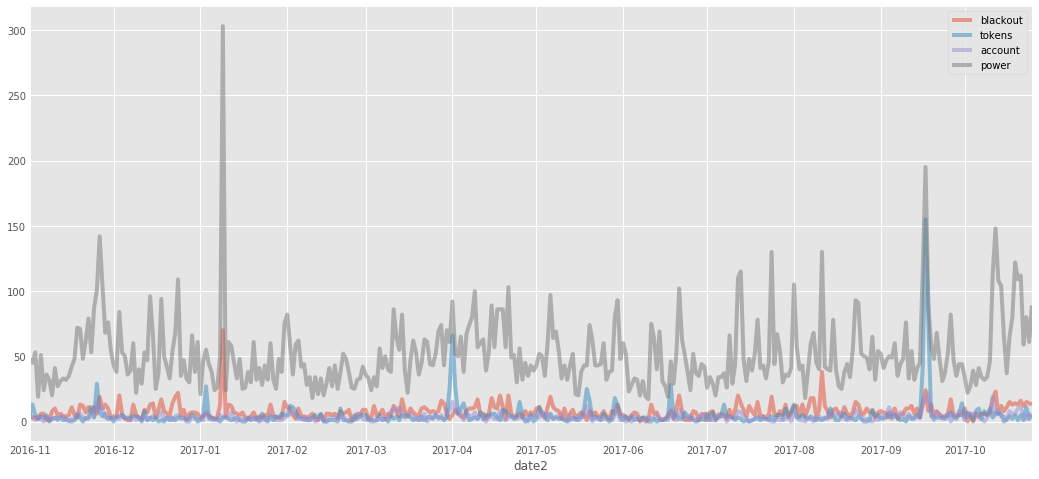

In [137]:
# df.groupby('date2')['username'].count().plot(kind='line',figsize=(16,8),alpha=0.5, label='total')
df.groupby('date2')['blackout'].sum().plot(kind='line',figsize=(16,8),alpha=0.5, label='blackout')
# df.groupby('date2')['light'].sum().plot(kind='line',figsize=(16,8),alpha=0.5,label='light')
df.groupby('date2')['tokens'].sum().plot(kind='line',figsize=(16,8),alpha=0.5,label='tokens')
df.groupby('date2')['account'].sum().plot(kind='line',figsize=(16,8),alpha=0.5,label='account')
df.groupby('date2')['power'].sum().plot(kind='line',figsize=(16,8),alpha=0.5,label='power')
plt.legend(loc='best')

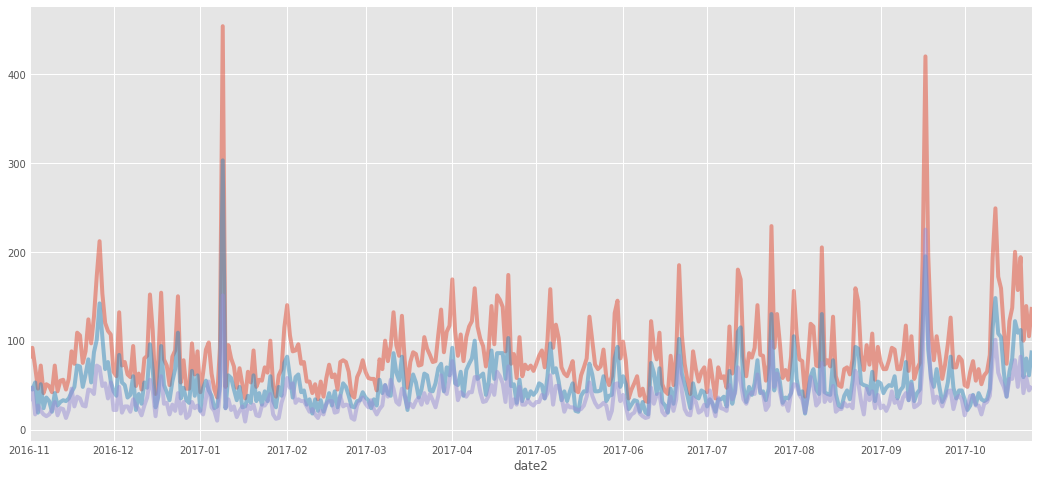

In [59]:
total_count = df.groupby('date2')['username'].count()
count_with_power = df.groupby('date2')['power'].sum()
difference = total_count - count_with_power
total_count.plot(kind='line',figsize=(16,8),alpha=0.5, label='total')
count_with_power.plot(kind='line',figsize=(16,8),alpha=0.5, label='power')
difference.plot(kind='line',figsize=(16,8),alpha=0.5, label='difference')

In [60]:
df['text'].head()

0    @KenyaPower_Care @KenyaPower @KenyaPowerAlert ...
1    @KenyaPowerAlert @KenyaPower what’s with the p...
2    For one week now there has no electricity in d...
3    @KenyaPower_Care @KenyaPowerAlert power outage...
4    @KenyaPower_Care @KenyaPowerAlert No power 284...
Name: text, dtype: object

In [61]:
def find_location(tweet, key_word, prefix=False):
    tweet = tweet.translate(None, string.punctuation)
    tweet = [t.lower() for t in tweet.split(' ')]
    if key_word in tweet:
        if prefix == False:
            location = tweet[tweet.index(key_word)-1:tweet.index(key_word)+1]
        else:
            location = tweet[tweet.index(key_word):tweet.index(key_word)+2]
        location.append('kenya')
        location = ' '.join(location)
    else:
        location = None
    return location

In [62]:
df['area'] = df['text'].apply(lambda x: find_location(x, 'area'))
df['road'] = df['text'].apply(lambda x: find_location(x, 'road'))
df['county'] = df['text'].apply(lambda x: find_location(x, 'county'))
df['estate'] = df['text'].apply(lambda x: find_location(x, 'estate'))
df['ward'] = df['text'].apply(lambda x: find_location(x, 'ward'))
df['town'] = df['text'].apply(lambda x: find_location(x, 'town'))
df['in'] = df['text'].apply(lambda x: find_location(x, 'in', True))




In [63]:
df.head(15)

,username,date,retweets,favorites,text,geo,mentions,hashtags,year,month,...,maintenance,nairobi,power,area,road,county,estate,ward,town,in
0,jossemwella,2017-10-25 12:32:00,0,0,@KenyaPower_Care @KenyaPower @KenyaPowerAlert ...,NaN,@KenyaPower_Care @KenyaPower @KenyaPowerAlert,NaN,2017,10,...,False,False,False,None,beach road kenya,None,village estate kenya,None,None,in beach kenya
1,kevinelegwa,2017-10-25 11:26:00,0,0,@KenyaPowerAlert @KenyaPower what’s with the p...,NaN,@KenyaPowerAlert @KenyaPower,NaN,2017,10,...,False,False,True,None,None,None,None,None,None,in nakuru kenya
2,EduWeez,2017-10-25 10:29:00,0,0,For one week now there has no electricity in d...,NaN,NaN,NaN,2017,10,...,False,False,False,None,None,None,None,None,None,in dandora kenya
3,wambuimugo,2017-10-25 08:34:00,0,0,@KenyaPower_Care @KenyaPowerAlert power outage...,NaN,@KenyaPower_Care @KenyaPowerAlert,NaN,2017,10,...,False,False,True,None,None,None,None,None,None,None
4,denniss_munene,2017-10-25 07:45:00,0,0,@KenyaPower_Care @KenyaPowerAlert No power 284...,NaN,@KenyaPower_Care @KenyaPowerAlert,NaN,2017,10,...,False,False,True,None,limuru road kenya,None,None,None,None,None
5,lilianngugi64,2017-10-25 07:09:00,0,0,@KenyaPower @KenyaPowerAlert @KenyaPower_Care ...,NaN,@KenyaPower @KenyaPowerAlert @KenyaPower_Care,NaN,2017,10,...,False,False,True,None,None,None,None,None,None,None
6,lizkmugo,2017-10-25 06:12:00,0,1,@KenyaPower @KenyaPower_Care @KenyaPowerAlert ...,NaN,@KenyaPower @KenyaPower_Care @KenyaPowerAlert,NaN,2017,10,...,False,False,True,None,None,None,None,None,None,None
7,kajujugicharuh,2017-10-25 05:19:00,0,0,"@KenyaPower , @KenyaPowerAlert kindly restore ...",NaN,@KenyaPower @KenyaPowerAlert,NaN,2017,10,...,False,False,True,None,None,None,None,None,None,None
8,ShiruMacharia,2017-10-25 03:26:00,0,0,"24 hours later were yet to assisted, is it bec...",NaN,NaN,NaN,2017,10,...,False,False,True,None,None,None,None,None,None,None
9,millergibbz,2017-10-24 10:16:00,0,0,So @KenyaPower @KenyaPowerAlert you have decid...,NaN,@KenyaPower @KenyaPowerAlert,NaN,2017,10,...,False,False,False,None,juja road kenya,None,None,None,None,None


In [65]:
df['road'].value_counts()

kenyatta road kenya             42
ojijo road kenya                42
the road kenya                  29
kangundo road kenya             27
naivasha road kenya             27
ngong road kenya                24
jogoo road kenya                23
limuru road kenya               21
kiambu road kenya               21
thika road kenya                21
nairobi road kenya              20
ack road kenya                  18
kikuyu road kenya               17
langata road kenya              15
riara road kenya                15
spine road kenya                14
kamiti road kenya               13
juja road kenya                 12
church road kenya               12
park road kenya                 12
outering road kenya             12
githunguri road kenya           12
kabete road kenya               11
mombasa road kenya              11
rhapta road kenya               11
gitanga road kenya              11
view road kenya                 10
popo road kenya                 10
north road kenya    

In [67]:
def get_coords(location):
    geolocator = Nominatim(country_bias='Kenya', timeout=4)
    if location == None:
        return None
    correct_coords = None
    geo_result = geolocator.geocode(location)
    if geo_result != None:
        coords = [geo_result.latitude, geo_result.longitude]
        correct_coords = coords
    return correct_coords


In [69]:
df['coords'] = df['road'].apply(lambda x : get_coords(x))

KeyboardInterrupt: 

In [468]:
df['coords_area'] = df['area'].apply(lambda x : get_coords(x))

KeyboardInterrupt: 

In [453]:
 geolocator = Nominatim(country_bias='Kenya', timeout=4)

In [460]:
geo_results = geolocator.geocode('migori town kenya')

In [461]:
[geo_results.latitude, geo_results.longitude]

[-1.0666, 34.4666]